In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

GPU name: NVIDIA GeForce RTX 2080 Ti, gpu_id: 0
cuda
pytorch version =  1.10.0


In [2]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch
from torch import Tensor
from torch_scatter import scatter
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_geometric.utils import remove_self_loops
try:
    from torch_cluster import knn
except ImportError:
    knn = None
from typing import Optional, Union
class TransEncoderNet(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes, nb_nodes+1) batch of attention scores
    """
    
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(TransEncoderNet, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + 2*ref), v_view).squeeze(2)
        
        return u, ref
    
class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c
    
class GravNetConv(MessagePassing):
    r"""The GravNet operator from the `"Learning Representations of Irregular
    Particle-detector Geometry with Distance-weighted Graph
    Networks" <https://arxiv.org/abs/1902.07987>`_ paper, where the graph is
    dynamically constructed using nearest neighbors.
    The neighbors are constructed in a learnable low-dimensional projection of
    the feature space.
    A second projection of the input feature space is then propagated from the
    neighbors to each vertex using distance weights that are derived by
    applying a Gaussian function to the distances.

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): The number of output channels.
        space_dimensions (int): The dimensionality of the space used to
           construct the neighbors; referred to as :math:`S` in the paper.
        propagate_dimensions (int): The number of features to be propagated
           between the vertices; referred to as :math:`F_{\textrm{LR}}` in the
           paper.
        k (int): The number of nearest neighbors.
        num_workers (int): Number of workers to use for k-NN computation.
            Has no effect in case :obj:`batch` is not :obj:`None`, or the input
            lies on the GPU. (default: :obj:`1`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V_s}|, F_{in}), (|\mathcal{V_t}|, F_{in}))`
          if bipartite,
          batch vector :math:`(|\mathcal{V}|)` or
          :math:`((|\mathcal{V}_s|), (|\mathcal{V}_t|))` if bipartite
          *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite


    """
    def __init__(self, in_channels: int, out_channels: int,
                 space_dimensions: int, propagate_dimensions: int, k: int,
                 num_workers: int = 1, **kwargs):
        super().__init__(flow='source_to_target', **kwargs)

        if knn is None:
            raise ImportError('`GravNetConv` requires `torch-cluster`.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k = k
        self.num_workers = num_workers

        self.lin_s = Linear(in_channels, space_dimensions)
        self.lin_h = Linear(in_channels, propagate_dimensions)

        self.lin_out1 = Linear(in_channels, out_channels, bias=False)
        self.lin_out2 = Linear(2 * propagate_dimensions, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_s.reset_parameters()
        self.lin_h.reset_parameters()
        self.lin_out1.reset_parameters()
        self.lin_out2.reset_parameters()


    def forward(
            self, x: Union[Tensor, PairTensor],
            batch: Union[OptTensor, Optional[PairTensor]] = None) -> Tensor:
        # type: (Tensor, OptTensor) -> Tensor  # noqa
        # type: (PairTensor, Optional[PairTensor]) -> Tensor  # noqa
        """"""

        is_bipartite: bool = True
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
            is_bipartite = False

        if x[0].dim() != 2:
            raise ValueError("Static graphs not supported in 'GravNetConv'")

        b: PairOptTensor = (None, None)
        if isinstance(batch, Tensor):
            b = (batch, batch)
        elif isinstance(batch, tuple):
            assert batch is not None
            b = (batch[0], batch[1])

        h_l: Tensor = self.lin_h(x[0])

        s_l: Tensor = self.lin_s(x[0])
        s_r: Tensor = self.lin_s(x[1]) if is_bipartite else s_l

        edge_index = knn(s_l, s_r, self.k, b[0], b[1]).flip([0])

        edge_weight = (s_l[edge_index[0]] - s_r[edge_index[1]]).pow(2).sum(-1)
        edge_weight = torch.exp(-10. * edge_weight)  # 10 gives a better spread

        # propagate_type: (x: OptPairTensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=(h_l, None),
                             edge_weight=edge_weight,
                             size=(s_l.size(0), s_r.size(0)))

        return self.lin_out1(x[1]) + self.lin_out2(out)


    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return x_j * edge_weight.unsqueeze(1)

    def aggregate(self, inputs: Tensor, index: Tensor,
                  dim_size: Optional[int] = None) -> Tensor:
        out_mean = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size,
                           reduce='mean')
        out_max = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size,
                          reduce='max')
        return torch.cat([out_mean, out_max], dim=-1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, k={self.k})')

class HPN(nn.Module):
    def __init__(self, n_feature, n_hidden):

        super(HPN, self).__init__()
        self.city_size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        # lstm for first turn
        #self.lstm0 = nn.LSTM(n_hidden, n_hidden)main_training - Jupyter Notebook
        
        # pointer layer
        self.TransPointer = Attention(n_hidden)
        self.Pointer = Attention(n_hidden)
        self.conv1 = GravNetConv(n_feature, n_hidden, space_dimensions=4, propagate_dimensions=22, k=40)
        self.conv2 = GravNetConv(n_hidden, n_hidden, space_dimensions=4, propagate_dimensions=22, k=40)
        self.conv3 = GravNetConv(n_hidden, n_hidden, space_dimensions=4, propagate_dimensions=22, k=40)
        # lstm encode2
        self.encoder = LSTM(n_hidden)
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        # trainable latent variable coefficient
        print('here') 
        alpha = torch.ones(1)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        
        self.alpha = nn.Parameter(alpha)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        self.denselayer1 = nn.Linear(n_hidden, n_hidden)
        self.denselayer2 = nn.Linear(n_hidden, n_hidden)
        self.Transembedding_all = TransEncoderNet(6, 128, 8, 512, batchnorm=True)#6,128,8,512
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
        self.outagg = nn.Linear(2, 1)
    
    def forward(self,GCNcontext,Transcontext, x, X_all, mask,choosen_idx,epoch, h=None, c=None, latent=None):
        '''
        Inputs (B: batch size, size: city size, dim: hidden dimension)
        
        x: current city coordinate (B, 2)
        X_all: all cities' cooridnates (B, size, 2)
        mask: mask visited cities
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent: latent pointer vector from previous layer (B, size, dim)
        
        Outputs
        
        softmax: probability distribution of next city (B, size)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent_u: latent pointer vector for next layer
        '''
        self.batch_size = X_all.size(0)
        self.city_size = X_all.size(1)
        zero_to_bsz = torch.arange(self.batch_size, device=device)
        batch = torch.arange(B)
        batch = batch.repeat_interleave(self.city_size)
        if torch.cuda.is_available():
            batch=batch.cuda()
        # Check if this the first iteration loop
        if h is None or c is None:
            x          = self.start_placeholder  
            
            #X_all = X_all.reshape(self.batch_size*self.city_size,dimension)
            context = self.embedding_all(X_all)
            X_all_normal = X_all/800
            Transcontext,_ = self.Transembedding_all(context)
            X_all_normal = X_all_normal.reshape(self.batch_size*self.city_size,dimension)
#             tempcontext = self.denselayer2(tempcontext)
#             tempcontext = tempcontext.reshape(self.batch_size*self.city_size,self.dim)
            tempcontext = self.conv1(X_all_normal, batch)
            tempcontext = self.denselayer1(tempcontext)
            GCNcontext = self.conv2(tempcontext, batch)
            #context = context.reshape(self.batch_size,-1,self.dim)
            
            #(B, size, dim)
            Transcontext = Transcontext.reshape(-1, self.dim)

            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        # LSTM encoder1900/2500
        h, c = self.encoder(x, h, c)
        # query vector
        q = h
        # pointer
        u2 ,_ = self.TransPointer(q, Transcontext)
        u1 ,_ = self.Pointer(q, GCNcontext)
        # Avg Agg between the two attention vector
        u = u1+u2
        latent_u = u.clone()
        u = 10 * torch.tanh(u)
        u = u + mask
        
        return GCNcontext, Transcontext,F.softmax(u, dim=1), h, c, latent_u
# params= list(HPN(n_feature = 2, n_hidden = 128).parameters())
# print(len(params))
# for name,parameters in HPN(n_feature = 2, n_hidden = 128).named_parameters():
#     print(name,':',parameters.size())

In [3]:
#test network 
Actor = HPN(n_feature = 2, n_hidden = 256)
print(Actor)
nb_param = 0
for param in Actor.parameters():
    nb_param += np.prod(list(param.data.size()))
print('Number of parameters:', nb_param)

here
HPN(
  (TransPointer): Attention(
    (Wref): Linear(in_features=256, out_features=256, bias=True)
    (Wq): Linear(in_features=256, out_features=256, bias=True)
  )
  (Pointer): Attention(
    (Wref): Linear(in_features=256, out_features=256, bias=True)
    (Wq): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv1): GravNetConv(2, 256, k=40)
  (conv2): GravNetConv(256, 256, k=40)
  (conv3): GravNetConv(256, 256, k=40)
  (encoder): LSTM(
    (Wxi): Linear(in_features=256, out_features=256, bias=True)
    (Whi): Linear(in_features=256, out_features=256, bias=True)
    (wci): Linear(in_features=256, out_features=256, bias=True)
    (Wxf): Linear(in_features=256, out_features=256, bias=True)
    (Whf): Linear(in_features=256, out_features=256, bias=True)
    (wcf): Linear(in_features=256, out_features=256, bias=True)
    (Wxc): Linear(in_features=256, out_features=256, bias=True)
    (Whc): Linear(in_features=256, out_features=256, bias=True)
    (Wxo): Linear(in_featur

# daniel rectangle feature handle

In [4]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def rectangle_process(temp,idx,Y,Y0,mask,k,B,i,path_gazebo, visit_count, visit_time_count, if_actor):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    if torch.cuda.is_available():
        feature_table = feature_table.cuda()
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    add_time = visit_time_count[zero_to_bsz, feature_table[:,0].data]*((range_of_wait/2)*speed_of_nozzle)
    if torch.cuda.is_available():
        add_time = add_time.cuda()
    Y_corner[:,dimension-2] = add_time
    
    if (i % 100 == 0)and(if_actor):
        path_gazebo.append([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
    if k ==0:
        if torch.cuda.is_available():
            reward = torch.zeros(B).cuda()
        else:
            reward = torch.zeros(B)
    if k > 0:
        reward = torch.sum((Y1[:,(0,1)] - Y0[:,(0,1)])**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner[:,(0,1)] - Y1[:,(0,1)])**2 , dim=1 )**0.5
        #dis = (Y1 - Y0)**2
        #dis_1 = (Y_corner - Y1)**2
        #reward = torch.maximum(dis[:,0],dis[:,1])**0.5
        #reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    visit_count[zero_to_bsz, idx.data] -= 1
    visit_count[zero_to_bsz, feature_table[:,0].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,1].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,2].data] -= 1
    visit_time_count[zero_to_bsz, idx.data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,0].data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,1].data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,2].data] += 1
    if_revisited = visit_count[zero_to_bsz, idx.data]<=0
    if_revisited = -np.inf*if_revisited
    if_revisited[if_revisited!=if_revisited] = 0
    mask[zero_to_bsz, idx.data] += if_revisited
    mask[zero_to_bsz, feature_table[:,0].data] += if_revisited
    mask[zero_to_bsz, feature_table[:,1].data ] += if_revisited  
    mask[zero_to_bsz, feature_table[:,2].data ] += if_revisited
    
    
    
    return Y, reward, Y_corner, Y_corner,feature_table[:,0]

In [5]:
# import torch
# import numpy as np
# from listofpathpoint import input_handler
# import cnc_input
# import copy
# import json
# def produce_random_data(boundry_recs, randomseed):
#     for i in range(0,len(boundry_recs),4):
#         np.random.seed(randomseed)
#         width = boundry_recs[i+2][0] - boundry_recs[i][0]
#         length = boundry_recs[i+2][1] - boundry_recs[i][1]
#         original_x,original_y = boundry_recs[i][0].clone(), boundry_recs[i][1].clone()
#         points_x = np.random.choice(int(width),2,replace=False)
#         points_y = np.random.choice(int(length),2,replace=False)
#         points_x.sort()
#         points_y.sort()
#         boundry_recs[i][0],boundry_recs[i][1] = (original_x + points_x[0]), (original_y + points_y[0])
#         boundry_recs[i+1][0],boundry_recs[i+1][1] = (original_x + points_x[1]), (original_y + points_y[0])
#         boundry_recs[i+2][0],boundry_recs[i+2][1] = (original_x + points_x[1]), (original_y + points_y[1])
#         boundry_recs[i+3][0],boundry_recs[i+3][1] = (original_x + points_x[0]), (original_y + points_y[1])
#     return boundry_recs
# def random_data_generator(origin_recs, batch_size):
#     result_X = torch.Tensor([])
#     for seed in range(batch_size):
#         temp_recs = origin_recs.clone()
#         temp_x = produce_random_data(temp_recs,seed)
#         result_X = torch.cat((result_X, temp_x),0)
#     result_X = result_X.reshape(batch_size,-1,temp_x.size(1))
#     return result_X

# test = input_handler('10&15data/25_chips/3corners_general.json')
# X_temp, mask_list_num = test.final_ver_points()
# X_temp = torch.FloatTensor(X_temp)
# # result = produce_random_data(X_temp,2)
# # result_1 = produce_random_data(X_temp,2)
# # now we have the produce_random_data, to produce single random data, but we need a batch of data...
# X_result = random_data_generator(X_temp, 128)
# for map_num in range(128):
#     gluewidth =[[354.0,320.0],[354.0,331.0],[387.0,330.0],[387.0,320.0]]
#     d = {
#     "version": "4.6.0",
#     "flags": {},
#     "shapes": [{"label":"gluewidth","points":gluewidth}]
#     }
#     for i in range(25):
#         dict = {}
#         dict["label"] = str(i)
#         dict["points"] = X_result[map_num][:,(0,1)][4*i:4*i+4].tolist()
#         d["shapes"].append(dict)

#     with open('10&15data/25_chips/3corners_generate'+str(map_num)+'.json', 'w') as f:
#         json.dump(d, f)

In [6]:
import numpy as np
a = np.array([1,2,4,3])
a.sort()
print(a)

[1 2 3 4]


prepare to train
Hyper parameters:
learning rate 0.0001
batch size 128
steps 500
epoch 100
here
here
tensor([ 3., 10., 24., 11., 21., 10., 19., 12., 11., 12., 19., 21.,  5., 18.,
         5., 13.,  8., 23.,  0., 23.,  8.,  4., 16., 16.,  2.,  1.,  1.,  6.,
        22.,  7.,  9., 20., 17., 22.,  7., 14., 14., 20., 15., 17.],
       device='cuda:0')
epoch:0, batch:100/500, reward:6796.1455078125


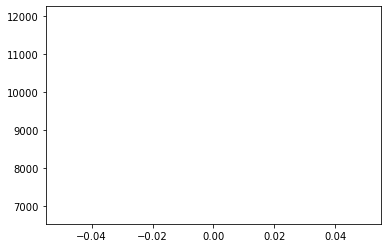

record the last path to gazebo for showing up


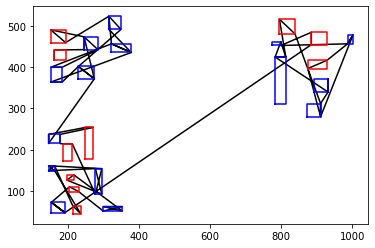

tensor([19., 10., 19., 24.,  3., 21., 11., 10., 21., 11., 12., 12., 18., 13.,
         5.,  5.,  2., 23.,  8.,  8.,  1.,  4.,  1., 23., 16., 16.,  0.,  7.,
        22., 22.,  9.,  7., 15.,  6., 17., 14., 17., 14., 20., 20.],
       device='cuda:0')
epoch:0, batch:200/500, reward:6132.873046875


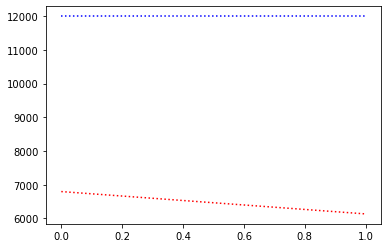

record the last path to gazebo for showing up


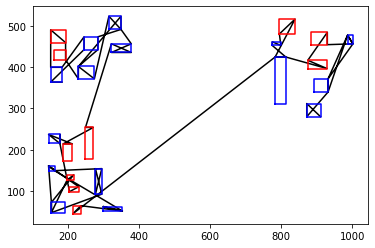

tensor([10., 24., 19., 11., 12., 11., 21., 21., 12.,  3., 19., 10.,  5.,  5.,
        18., 13., 23., 23.,  4.,  2.,  1.,  8.,  8.,  1.,  0., 16., 16.,  7.,
         7.,  6., 22., 22., 15.,  9., 14., 20., 17., 14., 17., 20.],
       device='cuda:0')
epoch:0, batch:300/500, reward:6336.34130859375


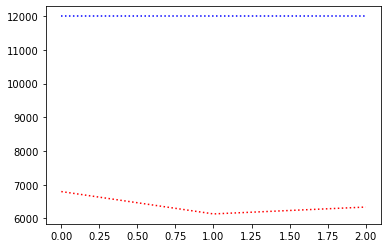

record the last path to gazebo for showing up


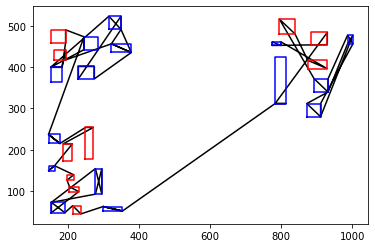

tensor([11., 12.,  3., 19., 24., 10., 11., 19., 21., 10., 21., 12.,  5., 18.,
         5., 13.,  8.,  1.,  4., 16., 23.,  8.,  0.,  1., 23.,  2., 16., 22.,
         7.,  7., 22.,  9., 15.,  6., 17., 17., 14., 14., 20., 20.],
       device='cuda:0')
epoch:0, batch:400/500, reward:6088.6474609375


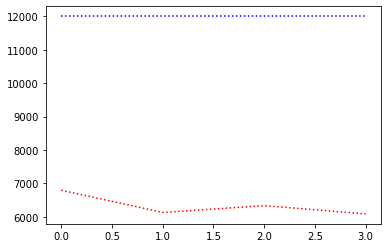

record the last path to gazebo for showing up


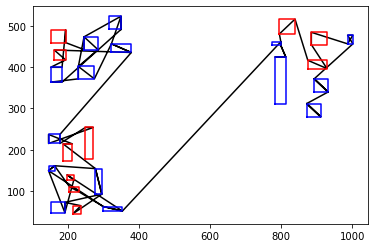

tensor([10., 24., 19., 10.,  3., 11., 12., 21., 12., 19., 21., 11., 18.,  5.,
         5., 23., 13., 23.,  4.,  0.,  8.,  8.,  2.,  1.,  1., 16., 16., 22.,
         7., 22.,  7.,  9., 17., 15.,  6., 17., 20., 20., 14., 14.],
       device='cuda:0')
epoch:0, batch:500/500, reward:6117.37548828125


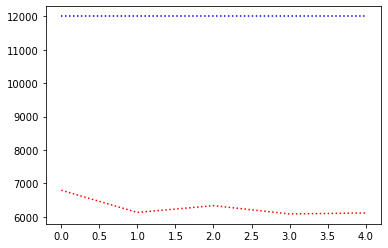

record the last path to gazebo for showing up


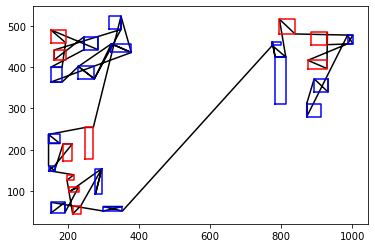

R_val =  tensor(5746.2593, device='cuda:0')
C_val =  tensor(8307.0498, device='cuda:0')
Avg Actor 5746.25927734375 --- Avg Critic 8307.0498046875
My actor is going on the right road Hallelujah :) Updated
Epoch: 0, epoch time: 8.887min, tot time: 0.006day, L_actor: 5746.259, L_critic: 8307.050, update: True
Save Checkpoints
tensor([19., 11., 10., 21., 12., 11., 24., 12.,  3., 21., 10., 19.,  5., 18.,
         5., 23., 23., 13.,  2.,  1.,  4.,  1.,  8.,  8.,  0., 16., 16., 22.,
        22.,  7.,  7.,  9.,  6., 15., 17., 17., 14., 14., 20., 20.],
       device='cuda:0')
epoch:1, batch:100/500, reward:5952.7099609375


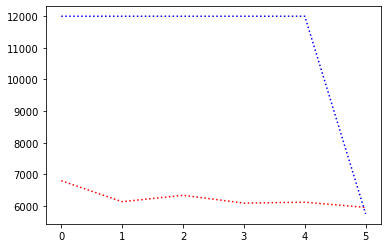

record the last path to gazebo for showing up


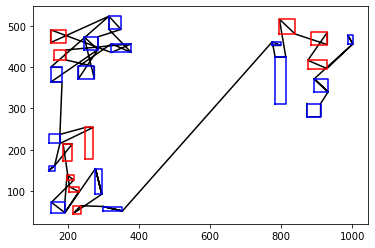

tensor([ 3., 10., 10., 21., 21., 11., 11., 24., 12., 12., 19., 19.,  5.,  5.,
        18., 13.,  4., 23., 23.,  2.,  8.,  1.,  8.,  1.,  0., 16., 16.,  9.,
        22., 22.,  7.,  7.,  6., 15., 17., 17., 14., 20., 14., 20.],
       device='cuda:0')
epoch:1, batch:200/500, reward:5836.40283203125


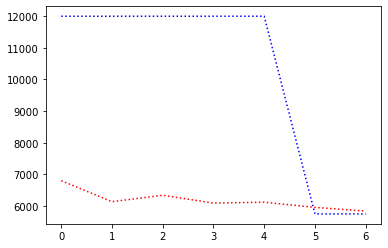

record the last path to gazebo for showing up


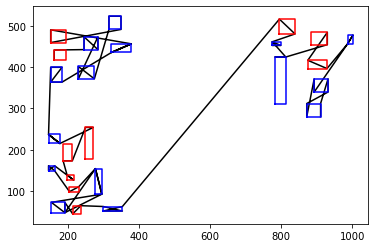

tensor([12., 11., 11., 10., 12., 10., 19., 21., 21., 19.,  3., 24.,  5., 18.,
         5., 23., 23., 13.,  4.,  8.,  2.,  8.,  1.,  1.,  0., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 15., 17., 17., 14., 14., 20., 20.],
       device='cuda:0')
epoch:1, batch:300/500, reward:5504.8603515625


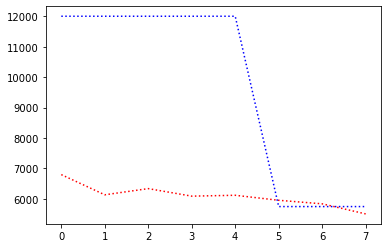

record the last path to gazebo for showing up


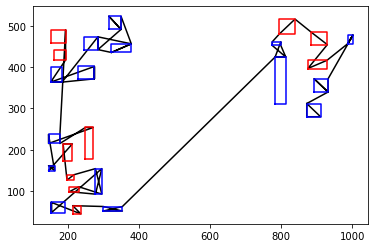

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
         5., 13., 23.,  1.,  2.,  4., 23.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         7., 22., 22.,  9.,  6., 17., 15., 17., 14., 14., 20., 20.],
       device='cuda:0')
epoch:1, batch:400/500, reward:5411.43798828125


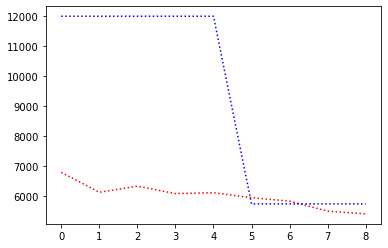

record the last path to gazebo for showing up


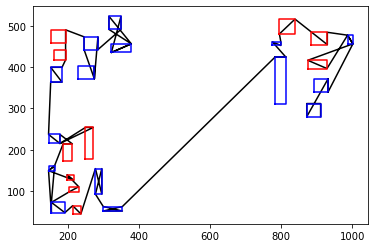

tensor([12., 11., 11., 21., 12., 10., 21., 10., 24.,  3., 19., 19., 18., 13.,
         5.,  5., 23., 23.,  2.,  1.,  4.,  1.,  0.,  8.,  8.,  7., 16., 16.,
        22., 22.,  7.,  9., 17.,  6., 17., 15., 20., 20., 14., 14.],
       device='cuda:0')
epoch:1, batch:500/500, reward:5350.955078125


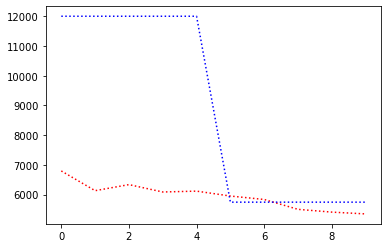

record the last path to gazebo for showing up


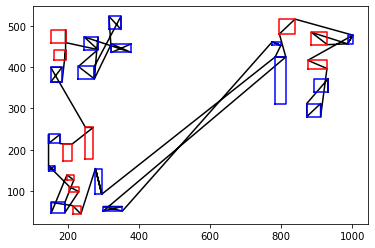

R_val =  tensor(5160.2578, device='cuda:0')
C_val =  tensor(5746.2593, device='cuda:0')
Avg Actor 5160.2578125 --- Avg Critic 5746.25927734375
My actor is going on the right road Hallelujah :) Updated
Epoch: 1, epoch time: 8.841min, tot time: 0.012day, L_actor: 5160.258, L_critic: 5746.259, update: True
Save Checkpoints
tensor([12., 10., 12., 11., 11., 10., 21., 21., 19., 24., 19.,  3., 18., 23.,
        13., 23.,  5.,  5.,  4.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16., 22.,
         7., 22.,  7.,  9.,  6., 14., 17., 17., 15., 14., 20., 20.],
       device='cuda:0')
epoch:2, batch:100/500, reward:5270.60009765625


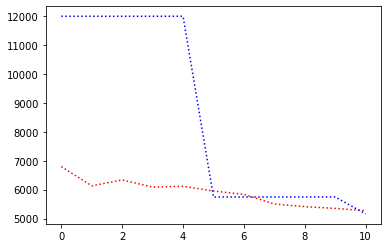

record the last path to gazebo for showing up


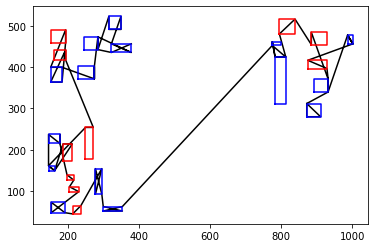

tensor([12., 12., 11., 11., 10., 10., 21., 21., 19.,  3., 24., 19., 18.,  5.,
        13.,  5., 23., 23.,  4.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  6.,  9., 17., 17., 15., 20., 20., 14., 14.],
       device='cuda:0')
epoch:2, batch:200/500, reward:5225.62939453125


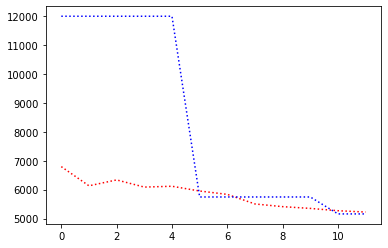

record the last path to gazebo for showing up


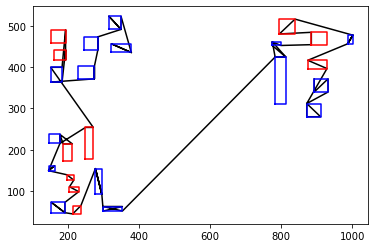

tensor([12., 12., 11., 21., 11., 10., 21., 10., 19., 24.,  3., 19., 18.,  5.,
        13.,  5., 23., 23.,  4.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22., 22.,  7.,  9.,  6., 17., 17., 15., 20., 20., 14., 14.],
       device='cuda:0')
epoch:2, batch:300/500, reward:5206.05517578125


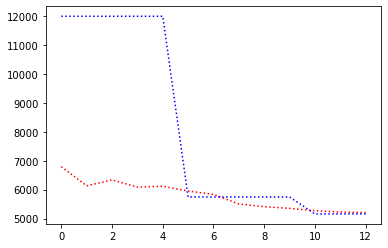

record the last path to gazebo for showing up


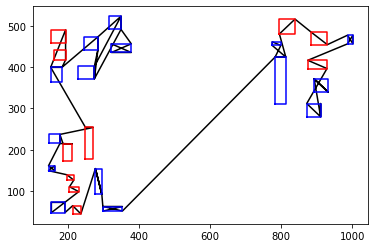

tensor([12., 11., 12., 11., 10., 10., 21., 21., 24., 19.,  3., 19., 18.,  5.,
         5., 13., 23., 23.,  4.,  2.,  0.,  1.,  1.,  8., 16.,  8., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:2, batch:400/500, reward:5155.96337890625


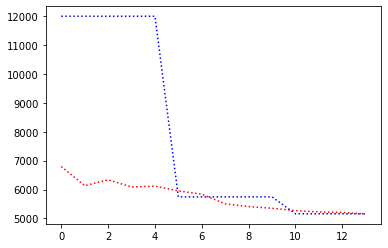

record the last path to gazebo for showing up


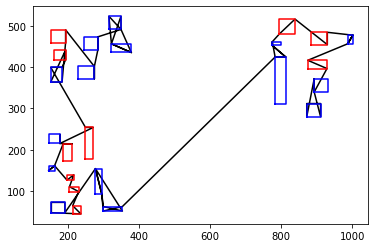

tensor([12., 11., 11., 12., 10., 21., 21., 10., 24.,  3., 19., 19., 18.,  5.,
        13.,  5., 23., 23.,  4.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         9., 22., 22.,  7.,  6., 17., 17., 15., 20., 20., 14., 14.],
       device='cuda:0')
epoch:2, batch:500/500, reward:5131.4794921875


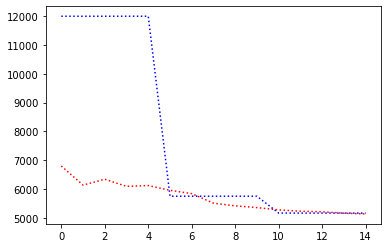

record the last path to gazebo for showing up


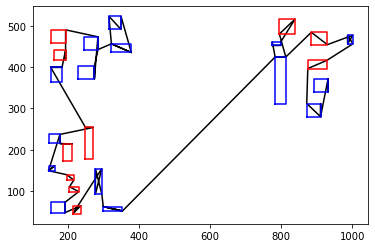

R_val =  tensor(5079.4028, device='cuda:0')
C_val =  tensor(5160.2578, device='cuda:0')
Avg Actor 5079.40283203125 --- Avg Critic 5160.2578125
My actor is going on the right road Hallelujah :) Updated
Epoch: 2, epoch time: 8.932min, tot time: 0.019day, L_actor: 5079.403, L_critic: 5160.258, update: True
Save Checkpoints
tensor([12., 12., 11., 11., 10., 10., 21., 21., 19., 24.,  3., 19., 13., 18.,
         5.,  5., 23., 23.,  4.,  1.,  2.,  0.,  1.,  8.,  8., 16., 16.,  7.,
         7., 22., 22.,  9.,  6., 17., 15., 17., 20., 20., 14., 14.],
       device='cuda:0')
epoch:3, batch:100/500, reward:5107.455078125


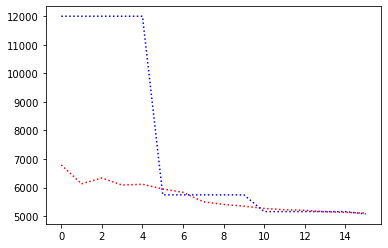

record the last path to gazebo for showing up


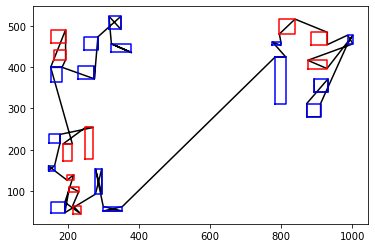

tensor([12., 12., 11., 11., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13., 23., 23.,  5.,  4.,  2.,  1.,  0.,  1.,  8.,  8., 16., 16.,  7.,
         7., 22., 22.,  9.,  6., 17., 17., 15., 20., 14., 14., 20.],
       device='cuda:0')
epoch:3, batch:200/500, reward:5070.37548828125


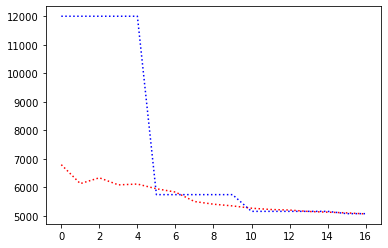

record the last path to gazebo for showing up


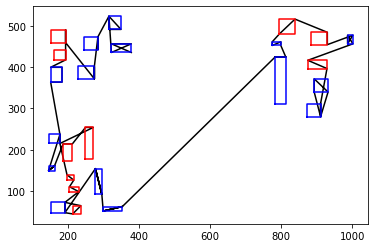

tensor([12., 11., 11., 12., 10., 10., 21., 21., 24.,  3., 19., 19., 18., 13.,
         5.,  5., 23., 23.,  4.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22., 22.,  7.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:3, batch:300/500, reward:5047.580078125


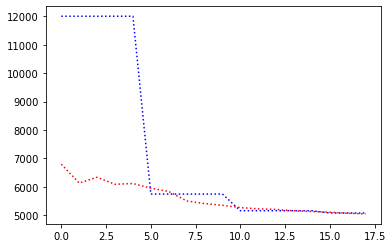

record the last path to gazebo for showing up


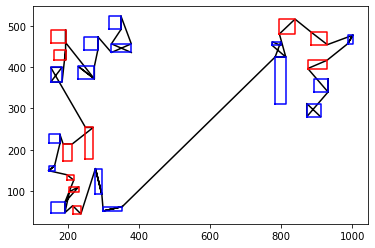

tensor([12., 11., 12., 11., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
         5., 13., 23., 23.,  4.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:3, batch:400/500, reward:5047.154296875


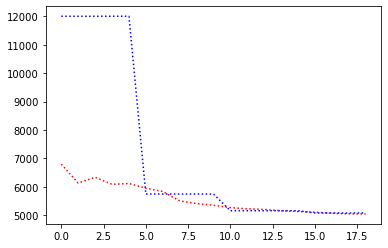

record the last path to gazebo for showing up


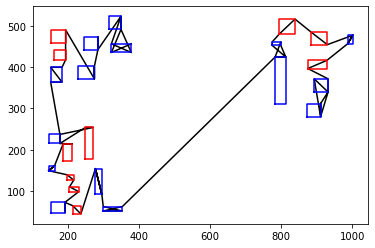

tensor([12., 11., 12., 11., 10., 21., 10., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23., 23.,  4.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 14., 20., 15., 14., 20.],
       device='cuda:0')
epoch:3, batch:500/500, reward:4979.9951171875


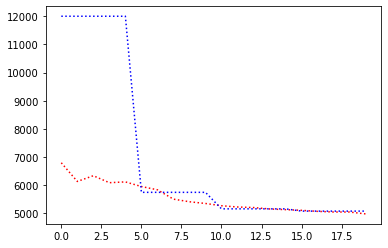

record the last path to gazebo for showing up


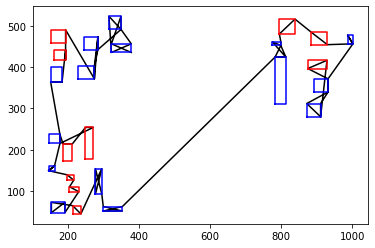

R_val =  tensor(4921.4307, device='cuda:0')
C_val =  tensor(5079.4028, device='cuda:0')
Avg Actor 4921.4306640625 --- Avg Critic 5079.40283203125
My actor is going on the right road Hallelujah :) Updated
Epoch: 3, epoch time: 8.871min, tot time: 0.025day, L_actor: 4921.431, L_critic: 5079.403, update: True
Save Checkpoints
tensor([12., 11., 10., 12., 11., 10., 21., 21., 24., 19., 19.,  3.,  4., 13.,
        18.,  5.,  5., 23., 23.,  2.,  1.,  0.,  1., 16.,  8.,  8., 16.,  7.,
         7., 22., 22.,  9., 17., 17.,  6., 15., 20., 14., 14., 20.],
       device='cuda:0')
epoch:4, batch:100/500, reward:4936.8271484375


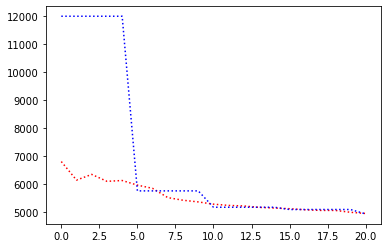

record the last path to gazebo for showing up


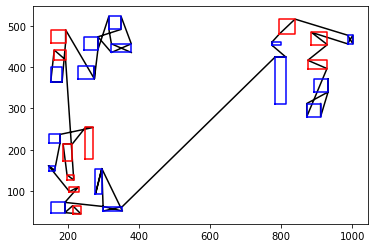

tensor([12., 12., 10., 11., 11., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5.,  4., 23., 23.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22., 22.,  7.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:4, batch:200/500, reward:4890.9052734375


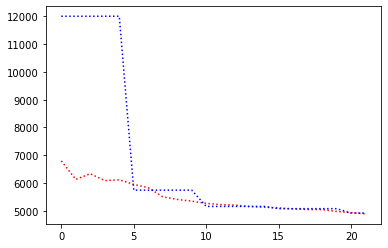

record the last path to gazebo for showing up


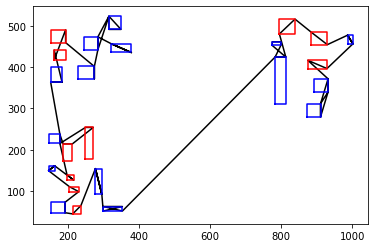

tensor([12., 11., 11., 10., 21., 10., 21., 12., 24., 19.,  3., 19.,  5., 18.,
        13.,  5.,  4., 23., 23.,  2.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:4, batch:300/500, reward:4853.322265625


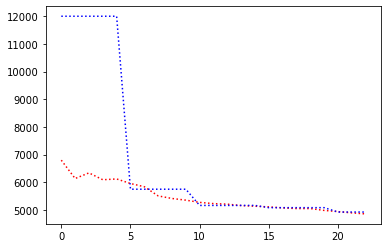

record the last path to gazebo for showing up


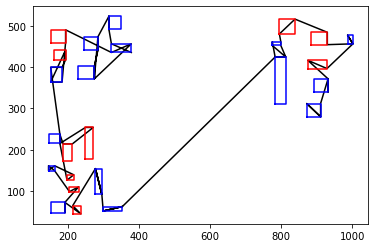

tensor([12., 12., 11., 11., 10., 21., 10., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         9.,  7., 22., 22.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:4, batch:400/500, reward:4860.25244140625


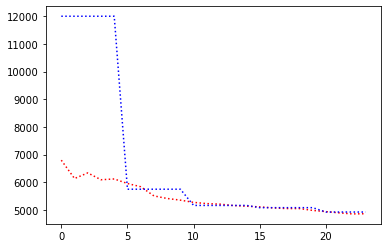

record the last path to gazebo for showing up


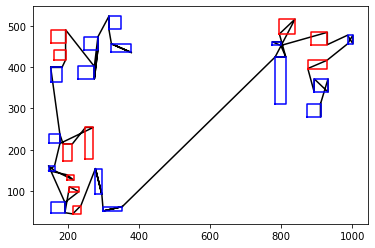

tensor([12., 11., 12., 11., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 14., 17., 17., 14., 15., 20., 20.],
       device='cuda:0')
epoch:4, batch:500/500, reward:4854.8203125


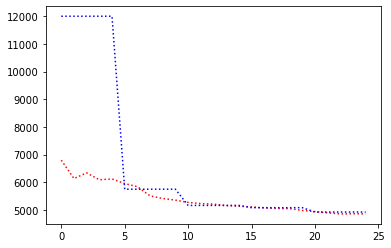

record the last path to gazebo for showing up


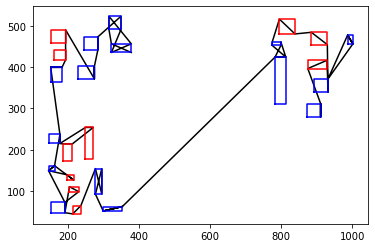

R_val =  tensor(4797.8179, device='cuda:0')
C_val =  tensor(4921.4307, device='cuda:0')
Avg Actor 4797.81787109375 --- Avg Critic 4921.4306640625
My actor is going on the right road Hallelujah :) Updated
Epoch: 4, epoch time: 8.938min, tot time: 0.031day, L_actor: 4797.818, L_critic: 4921.431, update: True
Save Checkpoints
tensor([12., 11., 10., 11., 12., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9., 17.,  6., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:5, batch:100/500, reward:4797.0419921875


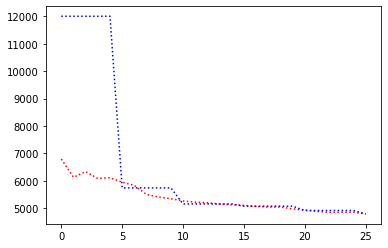

record the last path to gazebo for showing up


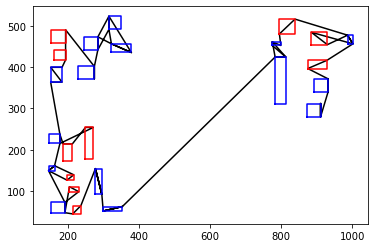

tensor([12., 11., 11., 12., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         7.,  9., 22., 22.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:5, batch:200/500, reward:4748.6328125


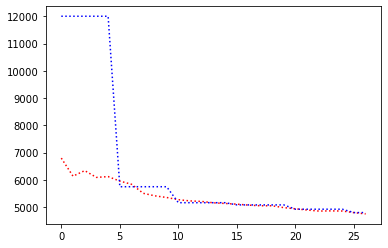

record the last path to gazebo for showing up


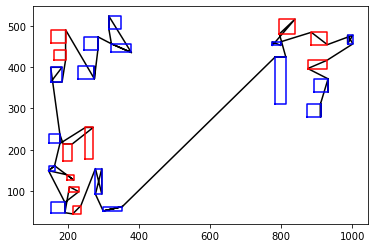

tensor([12., 11., 11., 12., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:5, batch:300/500, reward:4721.7919921875


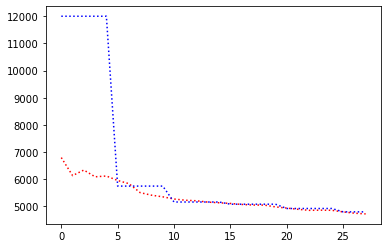

record the last path to gazebo for showing up


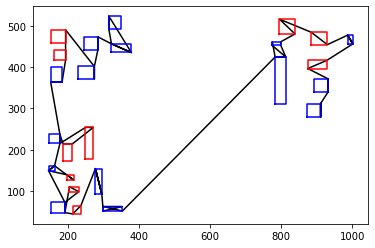

tensor([12., 21., 11., 11., 12., 10., 10., 21., 24., 19., 19.,  3., 18., 13.,
         5.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         7., 22., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:5, batch:400/500, reward:4713.51123046875


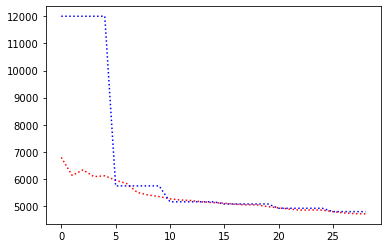

record the last path to gazebo for showing up


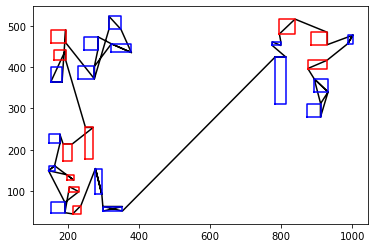

tensor([12., 12., 11., 11., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:5, batch:500/500, reward:4722.04345703125


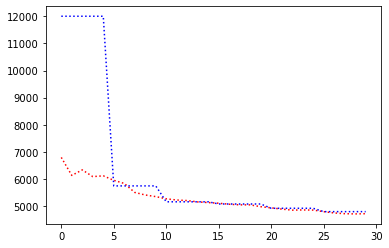

record the last path to gazebo for showing up


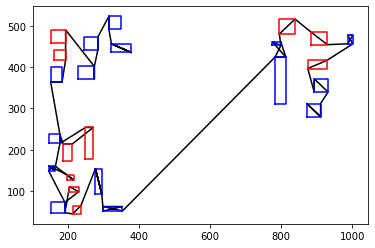

R_val =  tensor(4870.6035, device='cuda:0')
C_val =  tensor(4797.8179, device='cuda:0')
Avg Actor 4870.603515625 --- Avg Critic 4797.81787109375
Epoch: 5, epoch time: 8.829min, tot time: 0.037day, L_actor: 4870.604, L_critic: 4797.818, update: False
Save Checkpoints
tensor([12., 12., 11., 11., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:6, batch:100/500, reward:4690.54443359375


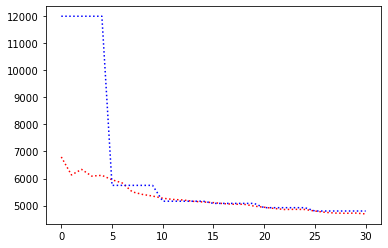

record the last path to gazebo for showing up


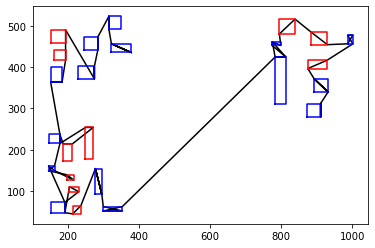

tensor([12., 11., 11., 12., 10., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         7., 22., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:6, batch:200/500, reward:4697.41748046875


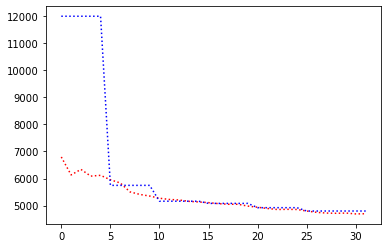

record the last path to gazebo for showing up


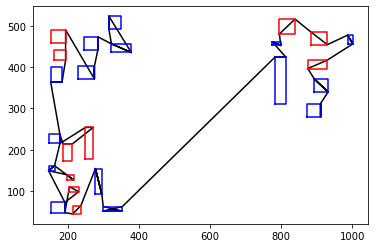

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:6, batch:300/500, reward:4679.96484375


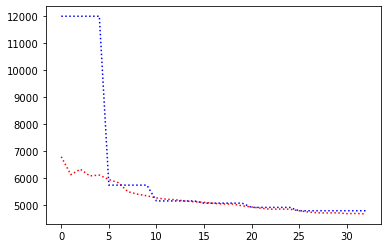

record the last path to gazebo for showing up


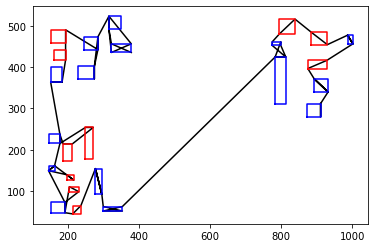

tensor([12., 12., 11., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 15., 17., 17., 14., 14., 20., 20.],
       device='cuda:0')
epoch:6, batch:400/500, reward:4678.2890625


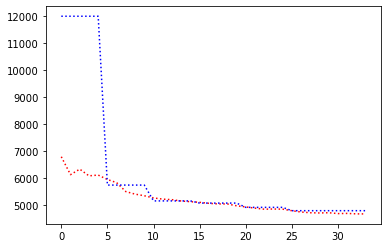

record the last path to gazebo for showing up


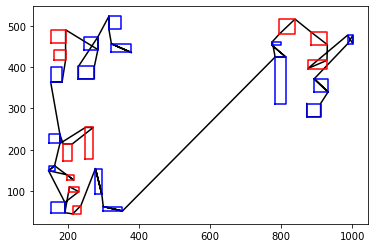

tensor([12., 11., 11., 12., 10., 10., 24., 21., 21.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  6.,  9., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:6, batch:500/500, reward:4677.6806640625


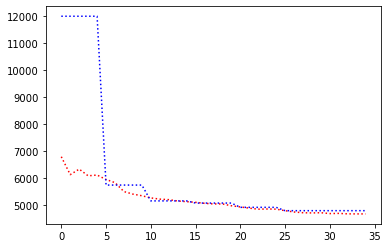

record the last path to gazebo for showing up


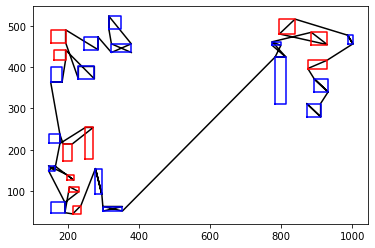

R_val =  tensor(4888.8506, device='cuda:0')
C_val =  tensor(4797.8179, device='cuda:0')
Avg Actor 4888.8505859375 --- Avg Critic 4797.81787109375
Epoch: 6, epoch time: 8.772min, tot time: 0.043day, L_actor: 4888.851, L_critic: 4797.818, update: False
Save Checkpoints
tensor([12., 11., 11., 10., 12., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22., 22.,  7.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:7, batch:100/500, reward:4677.2802734375


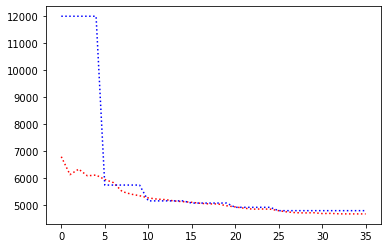

record the last path to gazebo for showing up


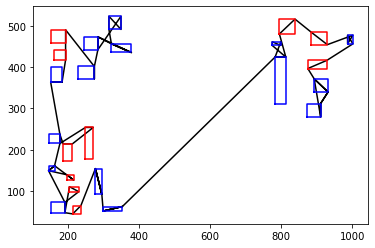

tensor([12., 12., 11., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0., 16., 16.,  8.,  8.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:7, batch:200/500, reward:4678.810546875


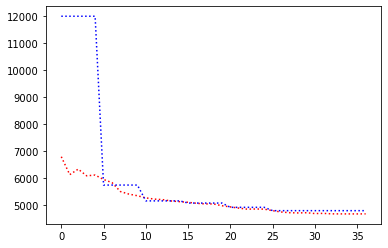

record the last path to gazebo for showing up


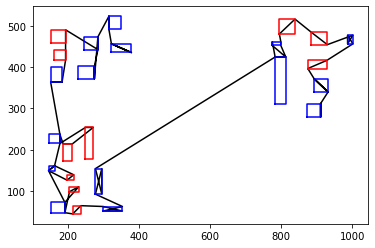

tensor([12., 11., 21., 12., 11., 10., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         7., 22., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:7, batch:300/500, reward:4694.8896484375


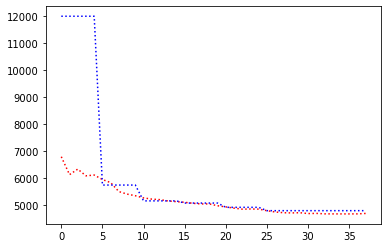

record the last path to gazebo for showing up


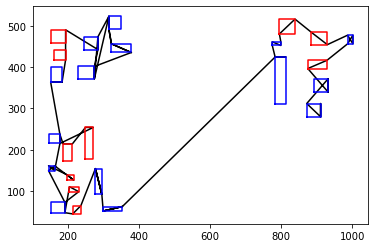

tensor([12., 11., 11., 12., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:7, batch:400/500, reward:4654.671875


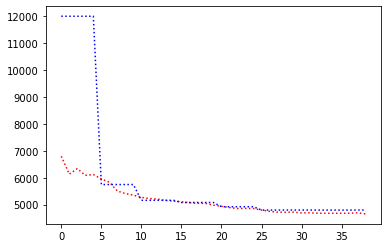

record the last path to gazebo for showing up


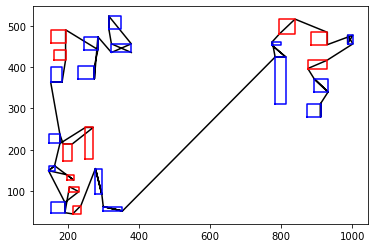

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:7, batch:500/500, reward:4651.611328125


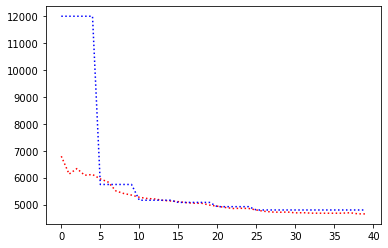

record the last path to gazebo for showing up


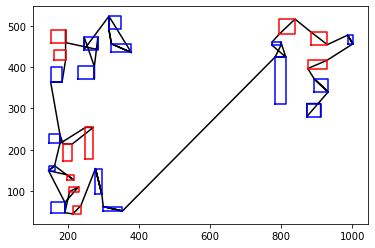

R_val =  tensor(4515.4336, device='cuda:0')
C_val =  tensor(4797.8179, device='cuda:0')
Avg Actor 4515.43359375 --- Avg Critic 4797.81787109375
My actor is going on the right road Hallelujah :) Updated
Epoch: 7, epoch time: 8.882min, tot time: 0.049day, L_actor: 4515.434, L_critic: 4797.818, update: True
Save Checkpoints
tensor([12., 11., 12., 11., 10., 21., 10., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4.,  2., 23.,  1.,  1.,  0.,  8.,  8., 16., 16.,  7.,
         6., 22.,  7., 22.,  9., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:8, batch:100/500, reward:4671.3212890625


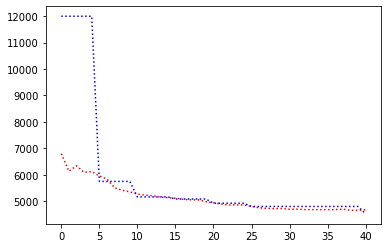

record the last path to gazebo for showing up


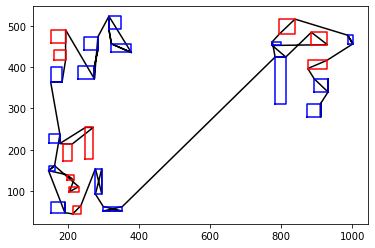

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22., 22.,  7.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:8, batch:200/500, reward:4591.6328125


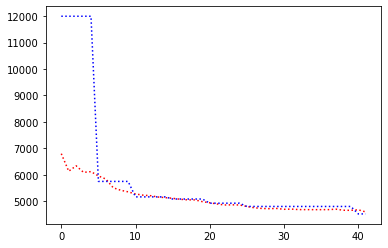

record the last path to gazebo for showing up


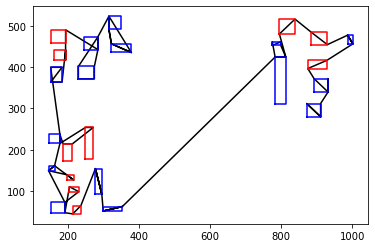

tensor([12., 11., 11., 12., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 20., 14., 20., 14.],
       device='cuda:0')
epoch:8, batch:300/500, reward:4565.0693359375


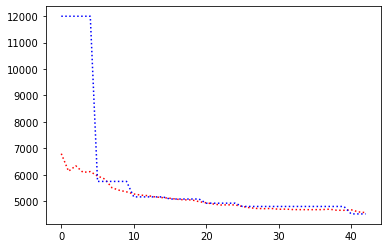

record the last path to gazebo for showing up


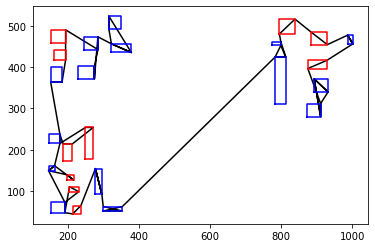

tensor([12., 11., 12., 10., 11., 10., 21., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:8, batch:400/500, reward:4558.4287109375


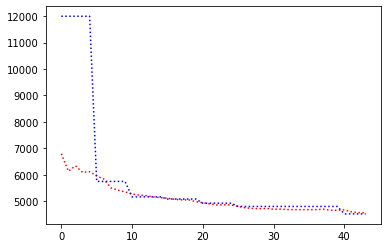

record the last path to gazebo for showing up


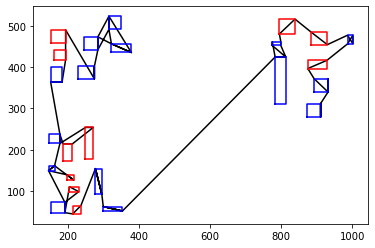

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:8, batch:500/500, reward:4527.8154296875


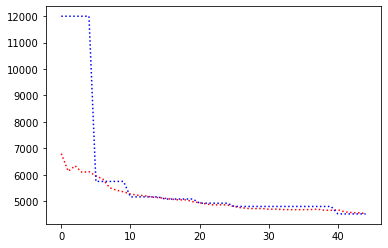

record the last path to gazebo for showing up


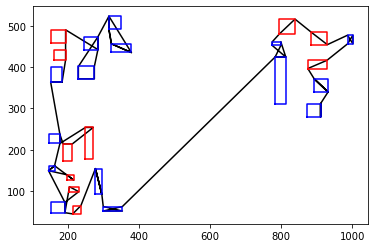

R_val =  tensor(4515.4336, device='cuda:0')
C_val =  tensor(4515.4336, device='cuda:0')
Avg Actor 4515.43359375 --- Avg Critic 4515.43359375
Epoch: 8, epoch time: 8.770min, tot time: 0.056day, L_actor: 4515.434, L_critic: 4515.434, update: False
Save Checkpoints
tensor([12., 11., 12., 11., 10., 21., 10., 21., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:9, batch:100/500, reward:4531.3779296875


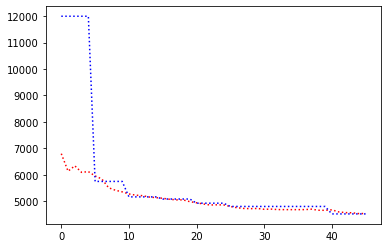

record the last path to gazebo for showing up


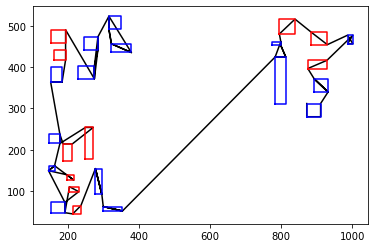

tensor([12., 12., 11., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:9, batch:200/500, reward:4530.05322265625


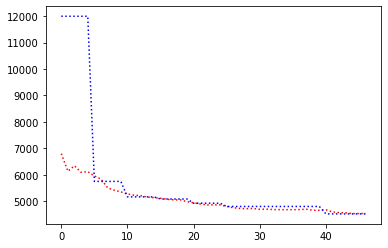

record the last path to gazebo for showing up


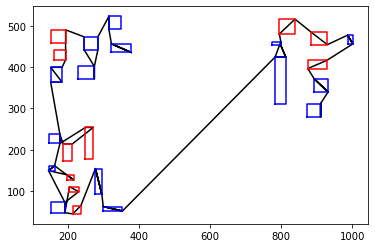

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 13.,
        18.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:9, batch:300/500, reward:4511.02490234375


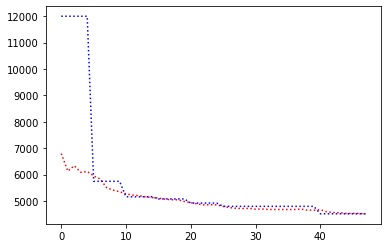

record the last path to gazebo for showing up


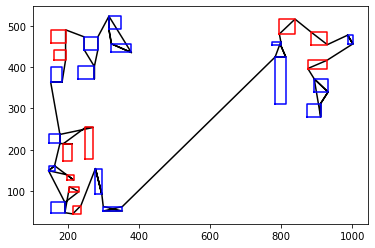

tensor([12., 11., 12., 11., 10., 21., 21., 24., 10.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:9, batch:400/500, reward:4501.5205078125


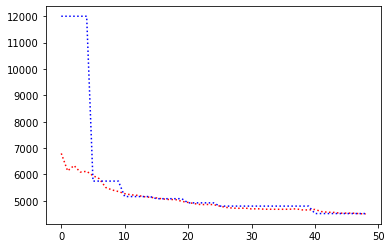

record the last path to gazebo for showing up


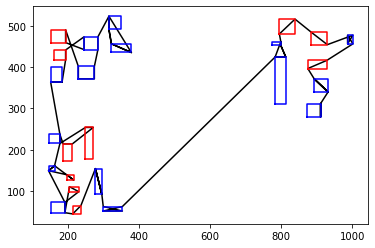

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7.,  9., 22.,  6., 17., 15., 17., 14., 14., 20., 20.],
       device='cuda:0')
epoch:9, batch:500/500, reward:4531.4150390625


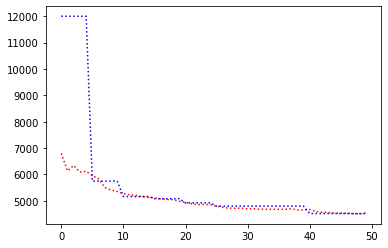

record the last path to gazebo for showing up


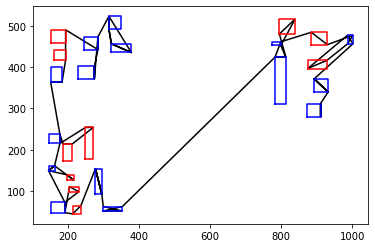

R_val =  tensor(4515.4336, device='cuda:0')
C_val =  tensor(4515.4336, device='cuda:0')
Avg Actor 4515.43359375 --- Avg Critic 4515.43359375
Epoch: 9, epoch time: 8.856min, tot time: 0.062day, L_actor: 4515.434, L_critic: 4515.434, update: False
Save Checkpoints
tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  9.,  7., 22.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:10, batch:100/500, reward:4491.0771484375


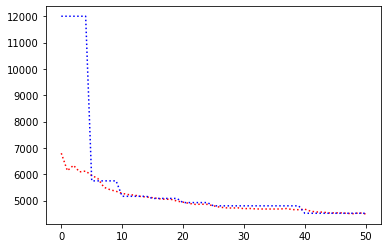

record the last path to gazebo for showing up


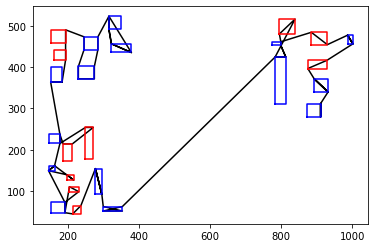

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:10, batch:200/500, reward:4486.23583984375


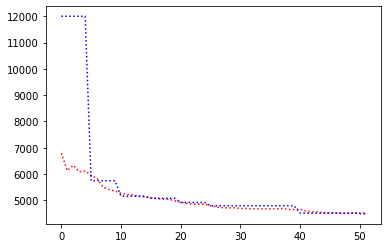

record the last path to gazebo for showing up


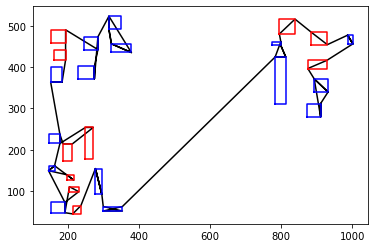

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:10, batch:300/500, reward:4520.69873046875


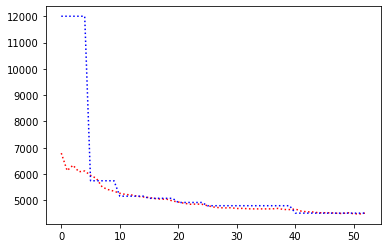

record the last path to gazebo for showing up


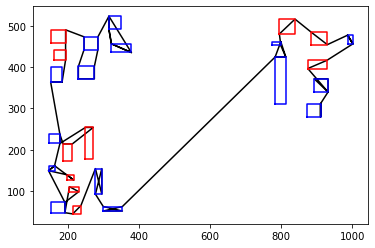

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:10, batch:400/500, reward:4478.45458984375


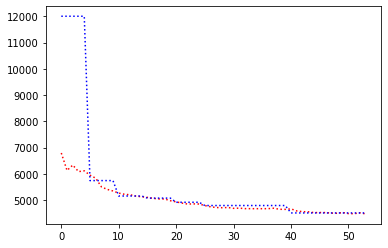

record the last path to gazebo for showing up


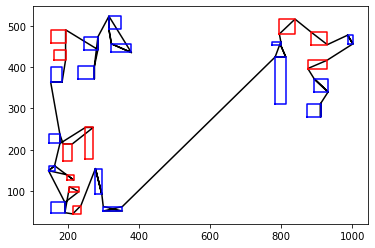

tensor([12., 11., 11., 12., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:10, batch:500/500, reward:4466.03515625


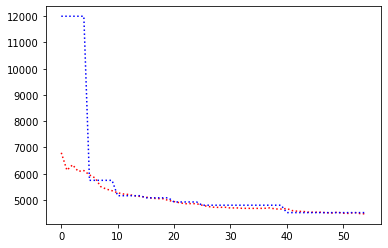

record the last path to gazebo for showing up


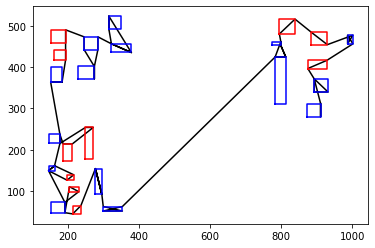

R_val =  tensor(4515.4336, device='cuda:0')
C_val =  tensor(4515.4336, device='cuda:0')
Avg Actor 4515.43359375 --- Avg Critic 4515.43359375
Epoch: 10, epoch time: 8.896min, tot time: 0.068day, L_actor: 4515.434, L_critic: 4515.434, update: False
Save Checkpoints
tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:11, batch:100/500, reward:4488.30126953125


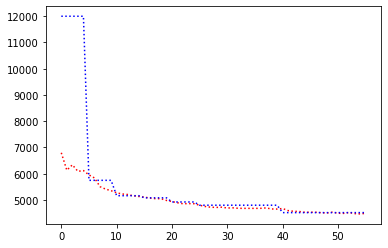

record the last path to gazebo for showing up


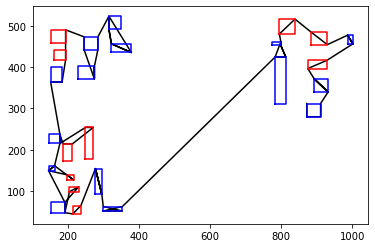

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 14., 20., 20.],
       device='cuda:0')
epoch:11, batch:200/500, reward:4463.7080078125


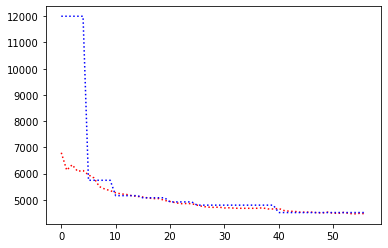

record the last path to gazebo for showing up


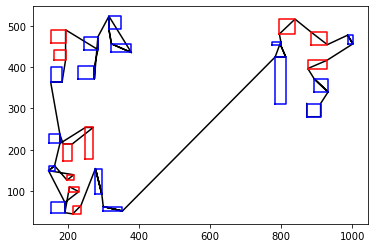

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:11, batch:300/500, reward:4480.03564453125


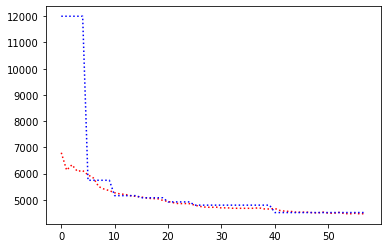

record the last path to gazebo for showing up


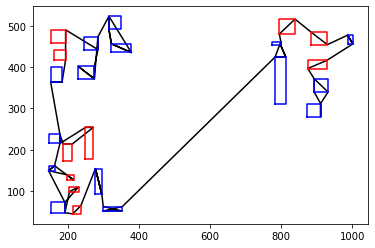

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:11, batch:400/500, reward:4447.7626953125


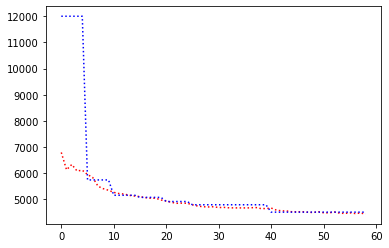

record the last path to gazebo for showing up


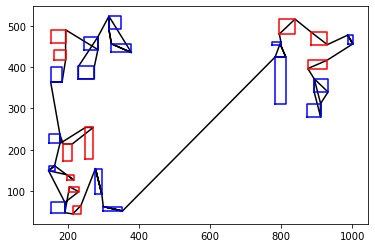

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:11, batch:500/500, reward:4434.689453125


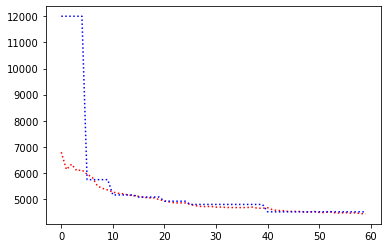

record the last path to gazebo for showing up


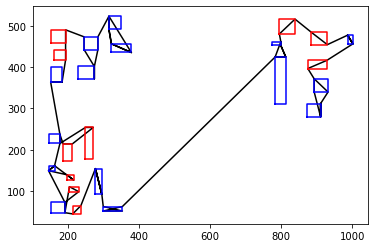

R_val =  tensor(4497.6494, device='cuda:0')
C_val =  tensor(4515.4336, device='cuda:0')
Avg Actor 4497.6494140625 --- Avg Critic 4515.43359375
My actor is going on the right road Hallelujah :) Updated
Epoch: 11, epoch time: 8.875min, tot time: 0.074day, L_actor: 4497.649, L_critic: 4515.434, update: True
Save Checkpoints
tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:12, batch:100/500, reward:4391.92041015625


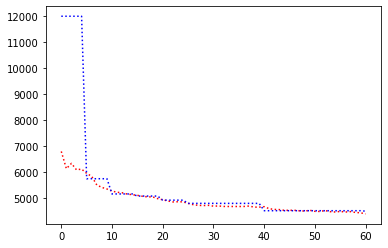

record the last path to gazebo for showing up


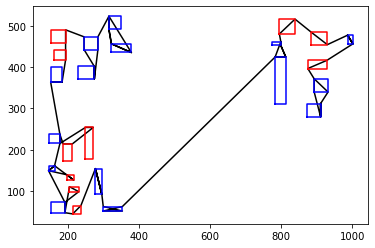

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:12, batch:200/500, reward:4384.32421875


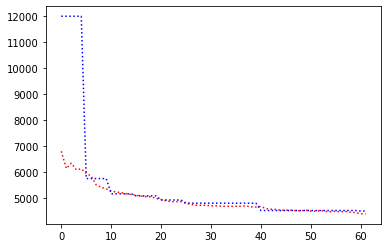

record the last path to gazebo for showing up


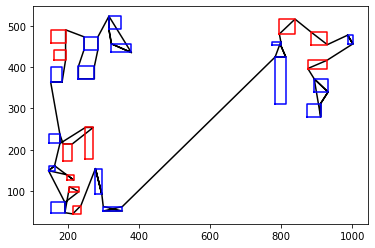

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:12, batch:300/500, reward:4383.2470703125


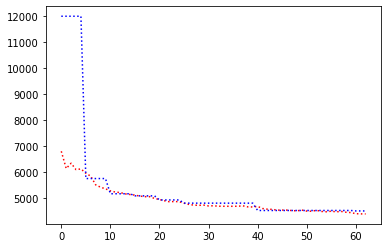

record the last path to gazebo for showing up


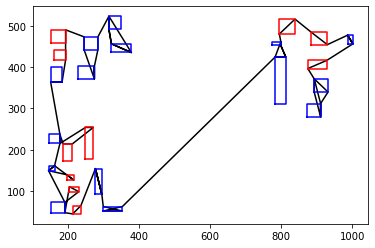

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:12, batch:400/500, reward:4382.8232421875


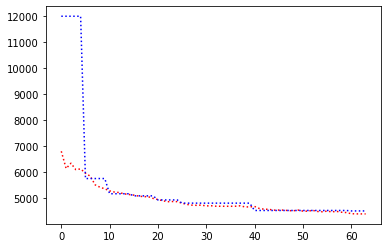

record the last path to gazebo for showing up


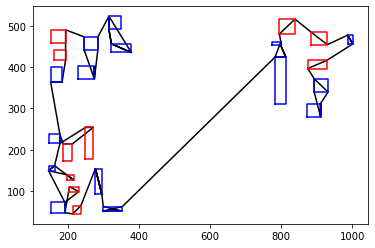

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:12, batch:500/500, reward:4359.85400390625


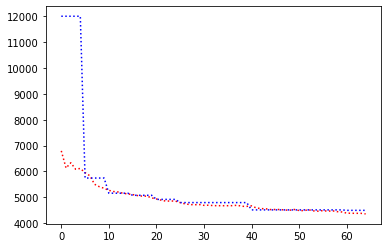

record the last path to gazebo for showing up


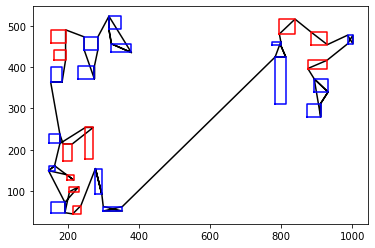

R_val =  tensor(4386.1060, device='cuda:0')
C_val =  tensor(4497.6494, device='cuda:0')
Avg Actor 4386.10595703125 --- Avg Critic 4497.6494140625
My actor is going on the right road Hallelujah :) Updated
Epoch: 12, epoch time: 8.931min, tot time: 0.080day, L_actor: 4386.106, L_critic: 4497.649, update: True
Save Checkpoints
tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:13, batch:100/500, reward:4361.0869140625


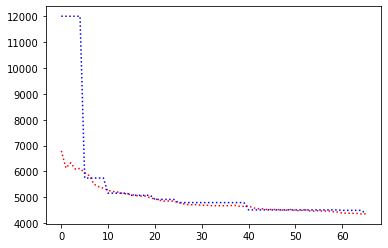

record the last path to gazebo for showing up


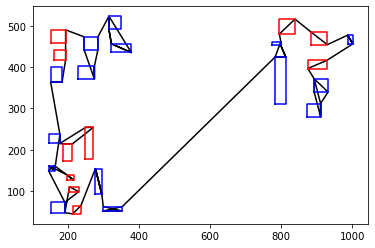

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  1.,  2.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:13, batch:200/500, reward:4374.90869140625


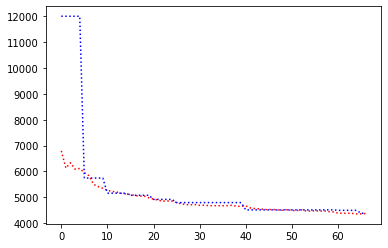

record the last path to gazebo for showing up


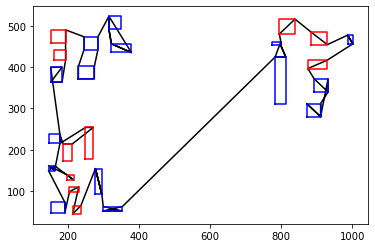

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 20., 14.],
       device='cuda:0')
epoch:13, batch:300/500, reward:4331.359375


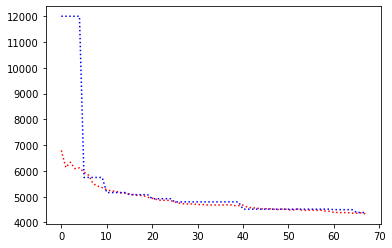

record the last path to gazebo for showing up


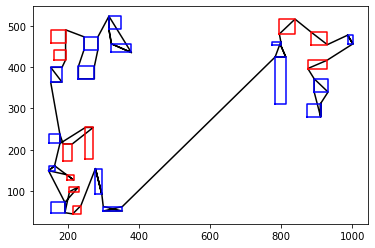

tensor([12., 11., 12., 11., 10., 21., 21., 10., 24.,  3., 19., 19.,  5., 18.,
        13.,  5., 23.,  4., 23.,  1.,  2.,  1.,  0.,  8.,  8., 16., 16.,  7.,
        22.,  7., 22.,  9.,  6., 17., 17., 15., 14., 20., 14., 20.],
       device='cuda:0')
epoch:13, batch:400/500, reward:4326.90673828125


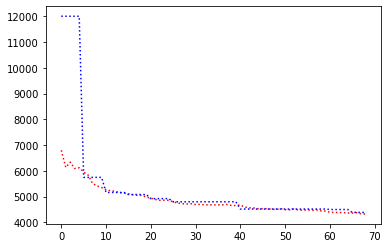

record the last path to gazebo for showing up


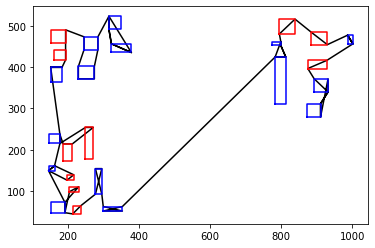

tensor([24., 12., 10.,  3., 19., 19., 11., 11., 10., 12., 21., 21.,  5.,  5.,
        13., 23., 23., 18.,  4.,  1.,  1.,  0.,  2.,  8., 16., 16.,  8., 15.,
         7.,  9., 14.,  7.,  6., 17., 14., 20., 17., 22., 22., 20.],
       device='cuda:0')
epoch:13, batch:500/500, reward:6647.765625


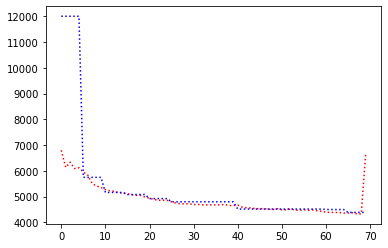

record the last path to gazebo for showing up


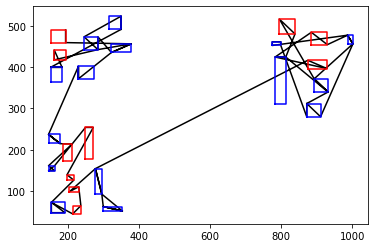

R_val =  tensor(6267.5137, device='cuda:0')
C_val =  tensor(4386.1060, device='cuda:0')
Avg Actor 6267.513671875 --- Avg Critic 4386.10595703125
Epoch: 13, epoch time: 8.716min, tot time: 0.086day, L_actor: 6267.514, L_critic: 4386.106, update: False
Save Checkpoints
tensor([ 3., 24., 12., 19., 11., 12., 11., 21., 21., 19., 10., 10.,  5., 13.,
         5., 18., 23., 23.,  4.,  8.,  8.,  2.,  1.,  1.,  0., 16., 16.,  7.,
        22., 15., 20.,  7., 17., 17.,  9., 22., 20.,  6., 14., 14.],
       device='cuda:0')
epoch:14, batch:100/500, reward:6592.7626953125


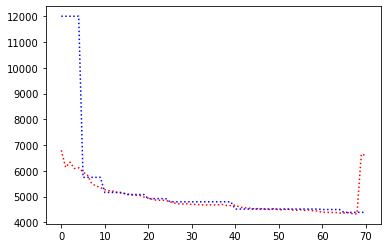

record the last path to gazebo for showing up


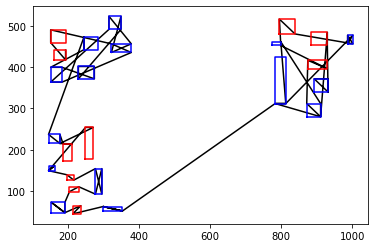

tensor([10., 21., 10., 24., 11., 11.,  3., 19., 19., 21., 12., 12.,  5.,  5.,
        13., 23., 18., 23.,  4.,  1.,  2.,  1.,  8.,  8.,  0., 16., 16.,  9.,
        20.,  6., 15., 20., 14., 17.,  7., 22.,  7., 17., 22., 14.],
       device='cuda:0')
epoch:14, batch:200/500, reward:6556.48828125


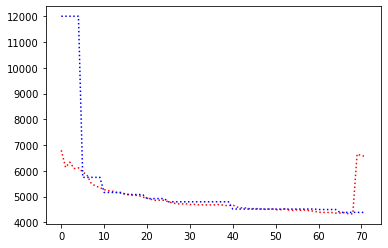

record the last path to gazebo for showing up


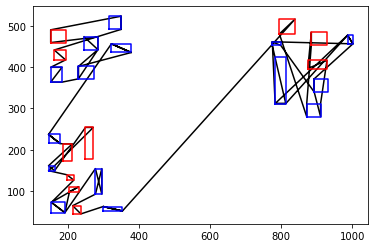

tensor([11., 10.,  3., 10., 19., 12., 12., 21., 11., 24., 21., 19., 18., 13.,
         5.,  5., 23., 23.,  4.,  2.,  8.,  1.,  1.,  8.,  0., 16., 16., 15.,
         9., 22., 17., 14., 22., 17., 14.,  7.,  6., 20.,  7., 20.],
       device='cuda:0')
epoch:14, batch:300/500, reward:6679.6171875


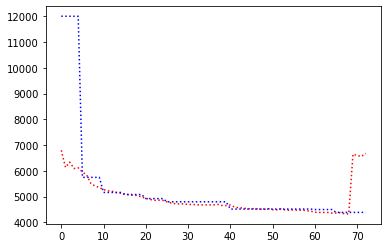

record the last path to gazebo for showing up


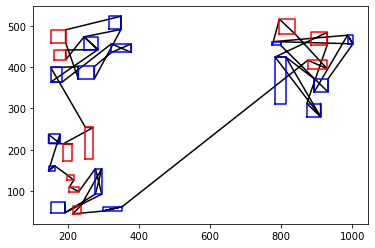

tensor([21., 19., 19., 10., 21., 10.,  3., 12., 11., 12., 11., 24., 18.,  5.,
         5., 23., 13., 23.,  4.,  1.,  2.,  1.,  8.,  8.,  0., 16., 16., 22.,
         7., 20.,  9., 15., 14., 22., 14., 17.,  6.,  7., 20., 17.],
       device='cuda:0')
epoch:14, batch:400/500, reward:6508.1181640625


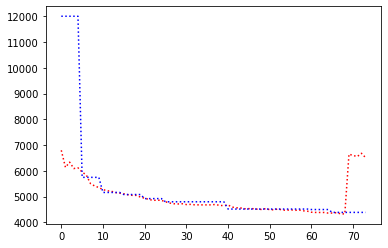

record the last path to gazebo for showing up


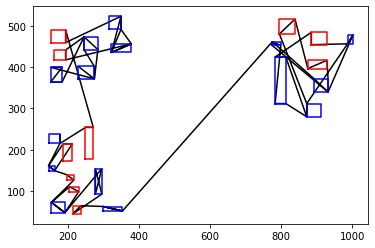

tensor([19., 19., 12., 10., 10., 24., 21.,  3., 21., 11., 12., 11.,  5., 18.,
        13.,  5., 23., 23.,  4.,  1.,  1.,  2.,  8.,  0.,  8., 16., 16.,  7.,
         6., 14., 20., 20., 15., 17., 22., 17.,  9.,  7., 22., 14.],
       device='cuda:0')
epoch:14, batch:500/500, reward:6462.4345703125


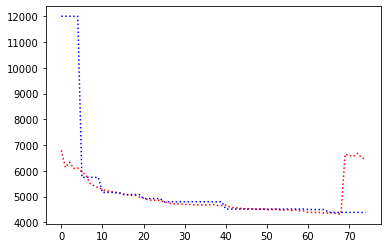

record the last path to gazebo for showing up


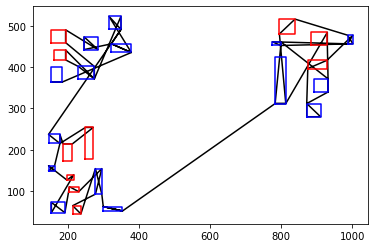

R_val =  tensor(6163.9980, device='cuda:0')
C_val =  tensor(4386.1060, device='cuda:0')
Avg Actor 6163.998046875 --- Avg Critic 4386.10595703125
Epoch: 14, epoch time: 8.591min, tot time: 0.092day, L_actor: 6163.998, L_critic: 4386.106, update: False
Save Checkpoints
tensor([10., 21., 19., 10., 12.,  3., 11., 19., 21., 12., 11., 24.,  5.,  5.,
        13., 18., 23., 23.,  1.,  1.,  2.,  4.,  0.,  8.,  8., 16., 16., 17.,
         6.,  9., 15., 17., 20.,  7., 14., 14., 22., 20., 22.,  7.],
       device='cuda:0')
epoch:15, batch:100/500, reward:6453.7001953125


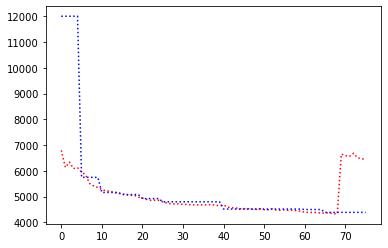

record the last path to gazebo for showing up


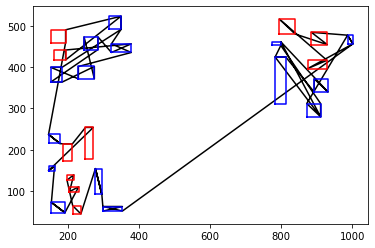

tensor([11., 12., 19.,  3., 12., 10., 11., 21., 19., 21., 24., 10.,  5.,  5.,
        18., 13., 23., 23.,  4.,  1.,  1.,  0.,  2.,  8.,  8., 16., 16., 14.,
         6., 14.,  7., 15., 17., 17., 22.,  9.,  7., 20., 22., 20.],
       device='cuda:0')
epoch:15, batch:200/500, reward:6467.08740234375


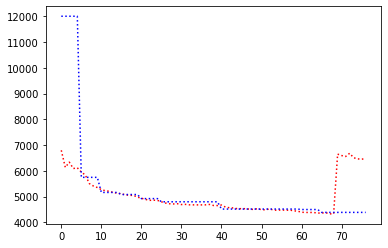

record the last path to gazebo for showing up


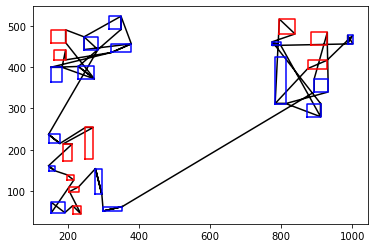

tensor([11., 12., 12., 10., 11., 24., 19., 10.,  3., 19., 21., 21.,  5.,  5.,
        13., 18., 23., 23.,  1.,  1.,  4.,  2.,  0.,  8.,  8., 16., 16., 22.,
        20., 15., 20., 22., 14., 17.,  6., 17., 14.,  9.,  7.,  7.],
       device='cuda:0')
epoch:15, batch:300/500, reward:6378.3154296875


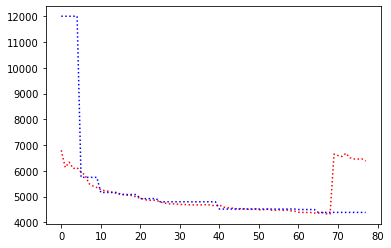

record the last path to gazebo for showing up


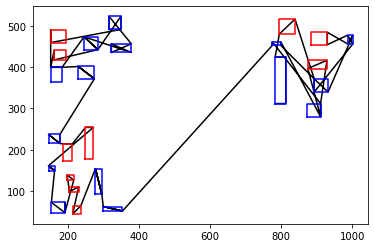

tensor([24., 10., 10., 19., 19., 21., 21., 11., 12., 12., 11.,  3.,  5.,  5.,
        13., 18., 23., 23.,  1.,  1.,  0.,  2.,  4.,  8.,  8., 16., 16.,  7.,
        14.,  6.,  9., 17., 17., 15., 22., 20.,  7., 20., 22., 14.],
       device='cuda:0')
epoch:15, batch:400/500, reward:6475.89111328125


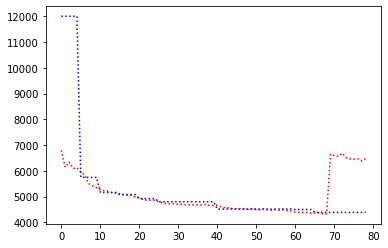

record the last path to gazebo for showing up


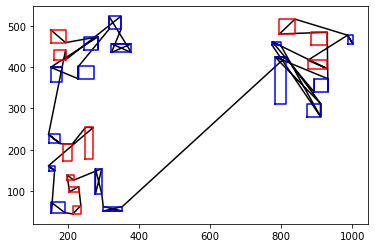

tensor([21.,  3., 24., 19., 11., 11., 21., 10., 12., 19.,  5., 10., 12.,  5.,
        18., 13., 23., 23.,  4.,  2.,  1.,  0.,  1.,  8.,  8., 16., 16., 22.,
        20.,  9., 17., 17., 22.,  7.,  6.,  7., 14., 15., 14., 20.],
       device='cuda:0')
epoch:15, batch:500/500, reward:6444.06982421875


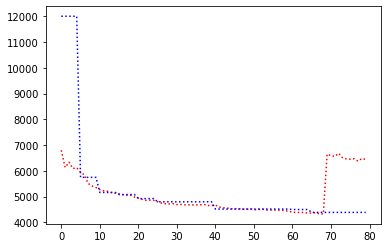

record the last path to gazebo for showing up


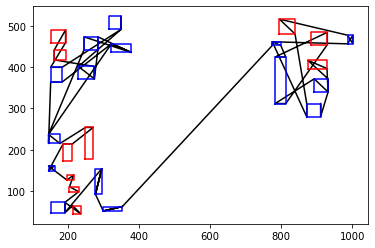

R_val =  tensor(5807.1079, device='cuda:0')
C_val =  tensor(4386.1060, device='cuda:0')
Avg Actor 5807.10791015625 --- Avg Critic 4386.10595703125
Epoch: 15, epoch time: 8.677min, tot time: 0.098day, L_actor: 5807.108, L_critic: 4386.106, update: False
Save Checkpoints
tensor([ 3., 10., 21., 19., 24., 12., 19., 21., 11., 12., 11., 10.,  5.,  5.,
        13., 18., 23., 23.,  1.,  1.,  4.,  2.,  0.,  8., 16.,  8., 16., 14.,
         6.,  7., 20., 17., 15.,  7., 14., 20.,  9., 22., 22., 17.],
       device='cuda:0')
epoch:16, batch:100/500, reward:6465.708984375


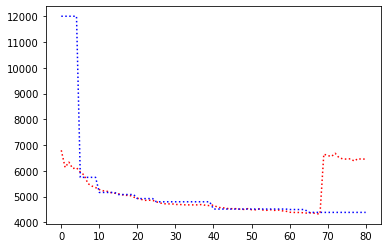

record the last path to gazebo for showing up


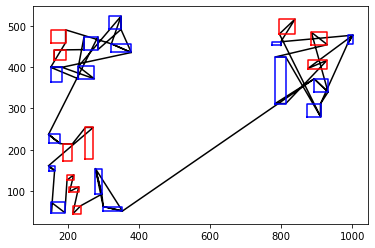

In [ ]:
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
import torch.nn.functional as F
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
import copy
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
TOL = 1e-3
TINY = 1e-15
learning_rate = 1e-4   #learning rate
B = 128          #batch size
B_valLoop = 1
steps = 500
n_epoch = 100       # epochs
map_number = 0
record_actor = []
record_critic = []
dimension = 4
speed_of_nozzle = 15
range_of_wait = 20
scale_of_the_map = (800,500,speed_of_nozzle*range_of_wait)
generalization_setup = False

print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''


try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = HPN(n_feature = dimension, n_hidden = 128)
Critic = HPN(n_feature = dimension, n_hidden = 128)
optimizer = optim.AdamW(Actor.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []
maplist = ['10&15data/25_chips/25_general.json'
          ]
          
plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point
"""
checkpoint_file = "checkpoint/grav3.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))

"""
#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic

start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward
temp = input_handler('10&15data/25_chips/25_3corners.json')
X_temp, mask_list_num = temp.final_ver_points()
#change the waiting time to the distance that we can measure
size = len(X_temp)
zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)

for corner in X_temp:
    corner[dimension -2] *= speed_of_nozzle
size_rec = mask_list_num[-1]

X_temp = torch.FloatTensor(X_temp)
visit_count_initial = X_temp[:,dimension-1]
visit_count_rec = []
for i in range(0,len(visit_count_initial),4):
    visit_count_rec.append(int(visit_count_initial[i]))
X = X_temp.repeat(B,1,1)
if torch.cuda.is_available():
    X = X.cuda()
C_critic = torch.Tensor([12000]) #********
if torch.cuda.is_available():#*******
    C_critic = C_critic.cuda()#*******
# in this step, if we want to variance the outputs, load the generalize .json and run the following code
# if generalization_setup == True:
#     X = random_data_generator(X_temp,B)
# else:
  
for epoch in range(0, n_epoch):
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    path_gazebo = []
#     temp = input_handler('10&15data/25_chips/3corners_generate'+str((epoch%B)+1)+'.json')
#     X_temp, mask_list_num = temp.final_ver_points()
#     #change the waiting time to the distance that we can measure
#     size = len(X_temp)
#     zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)

#     for corner in X_temp:
#         corner[dimension -2] *= speed_of_nozzle
#     size_rec = mask_list_num[-1]

#     X_temp = torch.FloatTensor(X_temp)
#     visit_count_initial = X_temp[:,dimension-1]
#     visit_count_rec = []
#     for i in range(0,len(visit_count_initial),4):
#         visit_count_rec.append(int(visit_count_initial[i]))

#     # C_critic = torch.Tensor([12000]) #********
#     # if torch.cuda.is_available():#*******
#     #     C_critic = C_critic.cuda()#*******
#     # in this step, if we want to variance the outputs, load the generalize .json and run the following code
#     if generalization_setup == True:
#         X = random_data_generator(X_temp,B)
#     else:
#         X = X_temp.repeat(B,1,1)
#     if torch.cuda.is_available():
#         X = X.cuda()
    for i_all in range(1, steps+1): # 1 ~ 2500 steps
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            logprobs = 0
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            logprobs = 0
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # Actor Sampling phase
        for k in range(size_rec):
            if k ==0:
                Y = X.view(B,size,dimension)
            context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,h=h,
                                                           c=c, mask=mask, choosen_idx=choosen_idx, 
                                                                       epoch=epoch+1)
            sampler = torch.distributions.Categorical(output)
            idx = sampler.sample()
            idx_recorder[:,k] = (idx/4).type(torch.long)
            #prepare for the back propagation of pytorch
            Y, reward, Y0, x, choosen_idx = rectangle_process(temp, idx,Y,Y0,mask,k,B,i_all,path_gazebo,
                                                visit_count, visit_time_count, if_actor=True)
            R += reward
            reward_recorder[:,k] = R
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
            
        #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

        trajec_count = 0
        if i_all%100 ==0:
            print(idx_recorder[0])
        for path_time in zip(idx_recorder,reward_recorder):
            idx_time = zip(path_time[0],path_time[1])
            idx_time = sorted(idx_time, key=lambda x: x[0])
            total_idx = 0
            extra_waiting_time = 0
            for item in visit_count_rec:
                compare_list = []
                if item>1:
                    for i in range(int(item)):
                        compare_list.append(idx_time[int(total_idx + i)][1])
                    compare_list.sort(reverse=True)
                    total_idx += item
                    for i in range(len(compare_list)-1):
                        dis_step = compare_list[i] - compare_list[i+1]
                        dry_time = (range_of_wait/2)*speed_of_nozzle
                        if (dis_step) < (dry_time):
                            extra_waiting_time += dry_time - dis_step
                else:
                    total_idx += item
            R[trajec_count] += extra_waiting_time
            trajec_count+=1
                    
                
        
#  # critic baseline phase, use the baseline to compute the actual reward of agent at that time
#         if torch.cuda.is_available():
#             C = torch.zeros(B).cuda()
#             reward_recorder = torch.zeros(B,size_rec).cuda()
#             idx_recorder = torch.zeros(B,size_rec).cuda()
#             baseline = torch.zeros(B).cuda()
#             mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
#         else:
#             C = torch.zeros(B)
#             reward_recorder = torch.zeros(B,size_rec)
#             idx_recorder = torch.zeros(B,size_rec)
#             baseline = torch.zeros(B)
#             mask = torch.zeros(B,size) # use mask to make some points impossible to choose
#         x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
#         h = None
#         c = None
#         context = None
#         Transcontext = None
#         C0 = None
#         choosen_idx = None
#         visit_count = visit_count_initial.repeat(B,1)
#         visit_time_count_initial = torch.zeros(len(visit_count_initial))
#         visit_time_count = visit_time_count_initial.repeat(B,1)
#         if torch.cuda.is_available():
#             visit_count = visit_count.cuda()
#         # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
#         with torch.no_grad():
#             for k in range(size_rec): 
#                 if k ==0:
#                     Y = X.view(B,size,dimension)
#                 #check if all the points to be masked,if so, raise the total reward R, and check again
#                 context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X,h=h,
#                                                                 c=c, mask=mask, choosen_idx=choosen_idx,epoch=epoch+1)
#                 idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
#                 idx_recorder[:,k] = (idx/4).type(torch.long)
#                 # prepare for the back propagation of pytorch
#                 Y, baseline, C0, x, choosen_idx = rectangle_process(temp,idx,Y,C0, mask,k,B,i,path_gazebo,
#                                                    visit_count, visit_time_count, if_actor=False)
#                 C += baseline
#                 reward_recorder[:,k] = C
#                     #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

#             trajec_count = 0
#             for path_time in zip(idx_recorder,reward_recorder):
#                 idx_time = zip(path_time[0],path_time[1])
#                 idx_time = sorted(idx_time, key=lambda x: x[0])
#                 total_idx = 0
#                 extra_waiting_time = 0
#                 for item in visit_count_rec:
#                     compare_list = []
#                     if item>1:
#                         for i in range(int(item)):
#                             compare_list.append(idx_time[int(total_idx + i)][1])
#                         compare_list.sort(reverse=True)
#                         total_idx += item
#                         for i in range(len(compare_list)-1):
#                             dis_step = compare_list[i] - compare_list[i+1]
#                             dry_time = (range_of_wait/2)*speed_of_nozzle
#                             if (dis_step) < (dry_time):
#                                 extra_waiting_time += dry_time - dis_step
#                     else:
#                         total_idx += item
#                 C[trajec_count] += extra_waiting_time
#                 trajec_count+=1
        ###################
        # Loss and backprop handling 
        ###################
#         loss = torch.mean((R - C) * logprobs)
        loss = 2*torch.mean((R - C_critic[0]) * logprobs) #*************************
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_all % 100 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i_all, steps,R.mean().item()))
            record_actor.append(R.mean().tolist())
#             record_critic.append(C.mean().tolist())#************************
            record_critic.append(C_critic[0].tolist())
            plt.plot(record_actor,'r:')
            plt.plot(record_critic,'b:')
            plt.show()
        if i_all % 100 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo,mask_list_num)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}
            pathpoints_dir = os.path.join("pathpoints")
            if not os.path.exists(pathpoints_dir):
                os.makedirs(pathpoints_dir)
            name = 'pathpoints/path_points '+str(i)+'.yaml'
            with open(name, 'w') as file:
                documents = yaml.dump(data,file)
                documents = yaml.dump(data_1,file)
            path_gazebo = []
    time_one_epoch = time.time() - start #recording the work time of one epoch
    time_tot = time.time() - start_training_time + tot_time_ckpt
    ###################
    # Evaluate train model and baseline 
    # in this phase we just solve random instances with the actor and the critic
    # compare this soluation if we get any improvment we'll transfer the actor's
    # weights into the critic
    ###################
    # putting the actor in the eval mode
    Actor.eval()
    
    mean_tour_length_actor = 0
    mean_tour_length_critic = 0

    for step in range(0,B_valLoop):
        # compute tour for model and baseline
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()

        with torch.no_grad():
            for k in range(size_rec):
                if k==0:
                    Y = X.view(B,size,dimension)
                context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,h=h,
                                                               c=c, mask=mask,choosen_idx=choosen_idx,epoch=epoch+1)
                idx = torch.argmax(output, dim=1)
                idx_recorder[:,k] = (idx/4).type(torch.long)
                #prepare for the back propagation of pytorch
                Y, reward, Y0, x, choosen_idx = rectangle_process(temp, idx,Y,Y0,mask,k,B,i,path_gazebo,
                                                    visit_count, visit_time_count, if_actor=False)
                R += reward
                reward_recorder[:,k] = R
            #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                R[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('R_val = ',R[0])
        if torch.cuda.is_available():
            C = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            baseline = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            C = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            baseline = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        C0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec): 
                if k ==0:
                    Y = X.view(B,size,dimension)
                #check if all the points to be masked,if so, raise the total reward R, and check again
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X,h=h,
                                                                c=c, mask=mask, choosen_idx=choosen_idx,epoch=epoch+1)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                idx_recorder[:,k] = (idx/4).type(torch.long)
                # prepare for the back propagation of pytorch
                Y, baseline, C0, x, choosen_idx = rectangle_process(temp,idx,Y,C0, mask,k,B,i,path_gazebo,
                                                   visit_count, visit_time_count, if_actor=False)
                C += baseline
                reward_recorder[:,k] = C
                    #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                C[trajec_count] += extra_waiting_time
                trajec_count+=1
#             print('C_val = ',C.mean().item())
            print('C_val = ',C[0])
        mean_tour_length_actor  += R.mean().item()
        mean_tour_length_critic += C.mean().item()

    mean_tour_length_actor  =  mean_tour_length_actor  / B_valLoop
    mean_tour_length_critic =  mean_tour_length_critic / B_valLoop
    # evaluate train model and baseline and update if train model is better

    update_baseline = mean_tour_length_actor + TOL < mean_tour_length_critic

    print('Avg Actor {} --- Avg Critic {}'.format(mean_tour_length_actor,mean_tour_length_critic))

    if update_baseline:
        Critic.load_state_dict(Actor.state_dict())
        C_critic = [R[0]] #********
        print('My actor is going on the right road Hallelujah :) Updated')
    ###################
    # Valdiation train model and baseline on 1k random TSP instances
    ###################
    # erased by daniel due to the 1K tsp is not the scale I want to train  

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_actor])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_critic])
    # compute the optimally gap ==> this is interesting because there is no LKH or other optimal algorithms 
    # for the problem like this rectangle characterized map
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_actor: {:.3f}, L_critic: {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_actor, mean_tour_length_critic, update_baseline)

    print(mystring_min)
    print('Save Checkpoints')

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'model_baseline': Critic.state_dict(),
        'model_train': Actor.state_dict(),
        'optimizer': optimizer.state_dict(),
        },'{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(size) + "-gpu{}".format(gpu_id)))


  




                
            
                
        
                        

In [ ]:
import torch
index = int(9.34)
table = [[1,2],[3,4]]
table_1 = [[3,44],[5,6]]
table = torch.as_tensor(table)
table_1 = torch.as_tensor(table_1)
result = torch.maximum(table_1[:,0],table_1[:,1])
print(result)

In [ ]:
import torch
t = torch.ones(10,2,2,2)
x = torch.ones(10,2,2)
k = x.unsqueeze(1)*2
x = x.unsqueeze(2)
print(x.shape)
print(k.shape)
print(t.shape)
X = t+x+k
print(X)

